In [1]:
# Importação as bibliotecas necessárias para conexão e coleta dos dados
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os

In [2]:
# Variaveis ambientes

host = os.environ.get('HOST_POSTGRE')
user = os.environ.get('USER_POSTGRE')
password = os.environ.get('PASSWORD_POSTGRE')

In [3]:
# Descrevo os parâmetros de conexão conforme configurado
db_server_info = {'host': host, 
                  'porta': 5432, 
                  'dbname': 'dbs_vacina',
                  'user': user, 
                  'password': password} 

conn_str = '{}://{}:{}@{}:{}/{}'.format('postgresql+psycopg2', 
                                  db_server_info['user'], 
                                  db_server_info['password'], 
                                  db_server_info['host'], 
                                  db_server_info['porta'], 
                                  db_server_info['dbname']) 

alchemyEngine = create_engine(conn_str, pool_recycle=3600)

postgreSQLConnection = alchemyEngine.connect() 

In [5]:
# Encontrando o id relacionado ao Distrito Federal

pd.read_sql_query("SELECT * FROM public.tbl_cidade WHERE uf = 'DF'", postgreSQLConnection)

,id,nm_municipio,uf,lat,lon,cd_ibge_reduzido
0,5300108,Brasília,DF,-15.8049,-47.88683,530010


In [5]:
# Dataframe de CEPs do DF

dfCepsDF = pd.read_sql_query("SELECT * FROM public.tbl_cep WHERE cidade_id = 5300108", postgreSQLConnection)
dfCepsDF.head()

,id,id_cidade,lat,lon
0,70002,5300108,-15.790840,-47.879656
1,70003,5300108,-15.790649,-47.880634
2,70037,5300108,-15.805816,-47.882790
3,70040,5300108,-15.791919,-47.884855
4,70041,5300108,-15.788176,-47.881767


In [6]:
# Dataframe de Estabelecimentos de Saúde do DF

ceps = dfCepsDF.id

dfEstab = pd.read_sql_query("SELECT * FROM pos.tbl_estabelecimento", postgreSQLConnection)

dfEstabDF = dfEstab.loc[dfEstab['id_cep'].isin(ceps)].copy()
dfEstabDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,id_tipo_estabelecimento,id_atividade_principal,lat,lon
296534,3266303,RONILDA SAUL HAAS,RONILDA SAUL HAAS,70100.0,4000.0,NaN,NaN,NaN,NaN
296662,3106632,FLAVIA DE PASSOS,FLAVIA DE PASSOS,70100.0,4000.0,NaN,NaN,NaN,NaN
296906,3464857,CLINICA CONIC LTDA,ECOGRAFIAS CONIC,70100.0,2000.0,NaN,NaN,NaN,NaN
297733,7966946,LIFE ODONTOLOGIA LTDA,LIFE ODONTOLOGIA,70200.0,2062.0,NaN,NaN,NaN,NaN
298171,3522032,STOMATUS ODONTOLOGIA LTDA,STOMATUS,70390.0,2000.0,NaN,NaN,NaN,NaN


In [7]:
# Quantidade de estabelecimentos de saúde no DF

dfEstabDF.shape

(8605, 9)

In [8]:
# Informações gerais do dataframe de estabelecimentos de saúde do DF

dfEstabDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8605 entries, 296534 to 325132
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       8605 non-null   int64  
 1   nm_razao_social          8605 non-null   object 
 2   nm_fantasia              8605 non-null   object 
 3   id_cep                   8605 non-null   float64
 4   id_natureza_juridica     8605 non-null   float64
 5   id_tipo_estabelecimento  4322 non-null   float64
 6   id_atividade_principal   4322 non-null   float64
 7   lat                      0 non-null      float64
 8   lon                      0 non-null      float64
dtypes: float64(6), int64(1), object(2)
memory usage: 672.3+ KB


In [9]:
# Dropando colunas com muitos valores ausentes

dfEstabDF.drop(columns = ['id_tipo_estabelecimento','id_atividade_principal','lat','lon'],axis=1,inplace=True)
dfEstabDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica
296534,3266303,RONILDA SAUL HAAS,RONILDA SAUL HAAS,70100.0,4000.0
296662,3106632,FLAVIA DE PASSOS,FLAVIA DE PASSOS,70100.0,4000.0
296906,3464857,CLINICA CONIC LTDA,ECOGRAFIAS CONIC,70100.0,2000.0
297733,7966946,LIFE ODONTOLOGIA LTDA,LIFE ODONTOLOGIA,70200.0,2062.0
298171,3522032,STOMATUS ODONTOLOGIA LTDA,STOMATUS,70390.0,2000.0


In [10]:
# Dataframe dos estabelecimentos de saúde que foram postos de vacinação no Brasil

dfEstabVacinacao = pd.read_sql_query("SELECT DISTINCT estabelecimento_id FROM pos.tbl_vacinacao", postgreSQLConnection)
dfEstabVacinacao.rename(columns={"estabelecimento_id": "id"},inplace=True)
dfEstabVacinacao.head()

,id
0,2442973
1,2496666
2,2718979
3,6039111
4,6822037


In [11]:
# Dataframe dos postos de vacinação do DF

dfPostosDF = pd.merge(dfEstabDF,dfEstabVacinacao)
dfPostosDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica
0,6268269,UBS 1 ITAPOA,UBS 1 ITAPOA,71593.0,1023.0
1,181552,DEMARTAMENTO MEDICO CAMARA DOS DEPUTADOS,DEPARTAMENTO MEDICO CAMARA DOS DEPUTADOS,70160.0,1040.0
2,11150,UNIDADE BASICA DE SAUDE N 1 ASA SUL,UBS 01 ASA SUL,70200.0,1023.0
3,10537,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,70203.0,1023.0
4,6362729,COMANDO DA MARINHA,HOSPITAL NAVAL DE BRASILIA,70310.0,1015.0


In [12]:
# Quantidade de postos de vacinação no DF

dfPostosDF.shape

(97, 5)

In [13]:
# Adicionando info de latitude e longitude nos postos de vacinação no DF

dfCepsDF.drop(columns='id_cidade',inplace=True)
dfCepsDF.rename(columns={"id":"id_cep"},inplace=True)
dfPostosDF = pd.merge(dfPostosDF,dfCepsDF,on='id_cep')
dfPostosDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon
0,6268269,UBS 1 ITAPOA,UBS 1 ITAPOA,71593.0,1023.0,-15.790914,-48.071726
1,181552,DEMARTAMENTO MEDICO CAMARA DOS DEPUTADOS,DEPARTAMENTO MEDICO CAMARA DOS DEPUTADOS,70160.0,1040.0,-15.800669,-47.861282
2,11150,UNIDADE BASICA DE SAUDE N 1 ASA SUL,UBS 01 ASA SUL,70200.0,1023.0,-15.821936,-47.890604
3,10537,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,70203.0,1023.0,-15.823910,-47.897709
4,6362729,COMANDO DA MARINHA,HOSPITAL NAVAL DE BRASILIA,70310.0,1015.0,-15.798626,-47.885490


In [14]:
# Adicionando informação de natureza jurídica dos postos de vacinação no DF

dfNatJur = pd.read_sql_query("SELECT * FROM pos.tbl_natureza_juridica", postgreSQLConnection)
dfNatJur.rename(columns={"id":"id_natureza_juridica"},inplace=True)
dfPostosDF = pd.merge(dfPostosDF,dfNatJur,on='id_natureza_juridica')
dfPostosDF.head()

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica
0,6268269,UBS 1 ITAPOA,UBS 1 ITAPOA,71593.0,1023.0,-15.790914,-48.071726,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
1,11150,UNIDADE BASICA DE SAUDE N 1 ASA SUL,UBS 01 ASA SUL,70200.0,1023.0,-15.821936,-47.890604,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
2,10537,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB,70203.0,1023.0,-15.823910,-47.897709,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
3,5117666,UNIDADE BASICA DE SAUDE N 5 ASA NORTE,UBS 5 GRANJA DO TORTO,70636.0,1023.0,-15.836922,-47.932855,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
4,10758,UNIDADE BASICA DE SAUDE N 2 CRUZEIRO,UBS 2 CRUZEIRO,70640.0,1023.0,-15.789750,-47.939987,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...


In [15]:
#Visão geral dos postos do DF

dfPostosDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 96
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    97 non-null     int64  
 1   nm_razao_social       97 non-null     object 
 2   nm_fantasia           97 non-null     object 
 3   id_cep                97 non-null     float64
 4   id_natureza_juridica  97 non-null     float64
 5   lat                   97 non-null     float64
 6   lon                   97 non-null     float64
 7   natureza_juridica     97 non-null     object 
dtypes: float64(4), int64(1), object(3)
memory usage: 6.8+ KB


In [16]:
# Analisando os dados de natureza jurídica
dfPostosDF.natureza_juridica.value_counts()

ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU DO DISTRITO FEDERAL    88
ORGAO PUBLICO DO PODER EXECUTIVO FEDERAL                             4
SERVICO SOCIAL AUTONOMO                                              2
FUNDACAO FEDERAL                                                     1
ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL                           1
FUNDACAO ESTADUAL OU DO DISTRITO FEDERAL                             1
Name: natureza_juridica, dtype: int64

In [17]:
# Lista de todos os pontos de vacinação do DF encontrados na base de dados

pd.set_option("max_rows", None)
dfPostosDF.nm_fantasia

0                                    UBS 1 ITAPOA
1                                  UBS 01 ASA SUL
2      HOSPITAL MATERNO INFANTIL DE BRASILIA HMIB
3                           UBS 5 GRANJA DO TORTO
4                                  UBS 2 CRUZEIRO
5                                            HRAN
6                                 UBS 2 ASA NORTE
7                                 UBS 1 ASA NORTE
8                   UBS 3 ASA NORTE VILA PLANALTO
9                    HOSPITAL REGIONAL DO GUARA I
10                                   UBS 01 GUARA
11                       UBS 04 GUARA LUCIO COSTA
12                              UBS 01 ESTRUTURAL
13                                   UBS 02 GUARA
14                                   UBS 03 GUARA
15                               UBS 1 LAGO NORTE
16                                   UBS 1 VARJAO
17                           UBS 3 PARANOA PARQUE
18                                            HRL
19                                  UBS 1 PARANOA


In [18]:
# Plotando os postos de vacinação do DF em um mapa
import folium as fl
import geopandas

m = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

dfPostosGeo = geopandas.GeoDataFrame(dfPostosDF, 
geometry = geopandas.points_from_xy(dfPostosDF.lon, dfPostosDF.lat))

for i in range(0,len(dfPostosGeo)):
  fl.Marker(
    [dfPostosGeo.loc[i,'lat'],dfPostosGeo.loc[i,'lon']],
    tooltip= dfPostosGeo.loc[i,'nm_fantasia'],
    icon=fl.Icon(color='blue')
    ).add_to(m)

m

In [19]:
# Algumas UBS estão bem distantes da área do DF. Como são 5 casos, vale a pena olhar caso a caso.

dfPostosGeo.loc[(dfPostosGeo['nm_fantasia'] == "UBS 1 GAMA")]

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica,geometry
60,10820,UBS 1 GAMA,UBS 1 GAMA,72415.0,1023.0,-15.288931,-48.594156,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,POINT (-48.59416 -15.28893)


In [20]:
dfPostosGeo.loc[(dfPostosGeo['nm_fantasia'] == "UBS 2 GAMA")]

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica,geometry
59,10839,UBS 2 GAMA,UBS 2 GAMA,72410.0,1023.0,-15.100514,-48.910861,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,POINT (-48.91086 -15.10051)


In [21]:
dfPostosGeo.loc[(dfPostosGeo['nm_fantasia'] == "UBS 3 GAMA")]

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica,geometry
63,10847,UBS 3 GAMA,UBS 3 GAMA,72457.0,1023.0,-17.343665,-47.186688,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,POINT (-47.18669 -17.34366)


In [22]:
dfPostosGeo.loc[(dfPostosGeo['nm_fantasia'] == "UBS 1 ENGENHO VELHO FERCAL")]

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica,geometry
83,2804360,UNIDADE BASICA DE SAUDE N 1 FERCAL,UBS 1 ENGENHO VELHO FERCAL,73150.0,1023.0,-16.60344,-47.933089,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,POINT (-47.93309 -16.60344)


In [23]:
dfPostosGeo.loc[(dfPostosGeo['nm_fantasia'] == "UBS 9 ENGENHO DAS LAGES GAMA")]

,id,nm_razao_social,nm_fantasia,id_cep,id_natureza_juridica,lat,lon,natureza_juridica,geometry
62,2779404,UBS 9 ENGENHO DAS LAGES GAMA,UBS 9 ENGENHO DAS LAGES GAMA,72426.0,1023.0,-15.751707,-48.269996,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,POINT (-48.27000 -15.75171)


In [24]:
#Verificando os dados na tabela da Secretária de Saúde do DF e vendo as USBs, foi notado que os CEPS estão corretos, mas as coordenadas lat/long estão bem diferentes. 
# http://www.saude.df.gov.br/wp-conteudo/uploads/joomla/238bab226de40145ad9645523074e6ce.pdf
# Será feita alteração das coordenadas no dataframe dfPostosDF e no dataframe dfPostosGeo

indices = [60,59,63,62,83]
lat_alt = [-16.020679,-16.036695,-16.005841,-16.04388,-15.600348]
lon_alt = [-48.084848,-48.06098,-48.052746,-48.254283,-47.8715]

for i, la, lo in zip(indices,lat_alt, lon_alt):
  dfPostosDF.iloc[i,5] = la
  dfPostosGeo.iloc[i,5] = la
  dfPostosDF.iloc[i,6] = lo
  dfPostosGeo.iloc[i,6] = lo

In [25]:
# Teste para ver se o loop anterior deu certo
dfPostosDF.iloc[60,]

id                                                                  10820
nm_razao_social                                                UBS 1 GAMA
nm_fantasia                                                    UBS 1 GAMA
id_cep                                                              72415
id_natureza_juridica                                                 1023
lat                                                              -16.0207
lon                                                              -48.0848
natureza_juridica       ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...
geometry                    POINT (-48.59415550889641 -15.28893084361635)
Name: 60, dtype: object

In [26]:
# Plotando novamente as UBs que são pontos de vacinação
from folium.plugins import MeasureControl

m1 = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

ubs = fl.FeatureGroup(name='UBS DF - Pontos de vacinação Covid-19')

for i in range(0,len(dfPostosGeo)):
  fl.Marker([dfPostosGeo.loc[i,'lat'],dfPostosGeo.loc[i,'lon']],
  tooltip= dfPostosGeo.loc[i,'nm_fantasia'],
  icon=fl.Icon(color='blue')
  ).add_to(ubs)

 
m1.add_child(ubs)
m1.add_child(MeasureControl())
m1.add_child(fl.LatLngPopup())
fl.LayerControl().add_to(m1)
m1

In [27]:
# Análise da tbl de vacinação no Brasil

dfVacinacao = pd.read_sql_query('SELECT hash_paciente,estabelecimento_id,data_aplicacao,dose_declarada FROM pos.tbl_vacinacao', postgreSQLConnection)
dfVacinacao.head()

,hash_paciente,estabelecimento_id,data_aplicacao,dose_declarada
0,5935b06dffac2d7c08e43629d6bbf2180ed6af1f57e8b4...,2088479,2021-03-26,2.0
1,a0d47a19ab54d027f5b7207b71b03c5b381f988a4551ea...,3507939,2021-03-23,1.0
2,70968780419de7b256241c63bd12a58ac8062fc456c4a8...,6461514,2021-03-30,1.0
3,1f2b24e0400319d4da94d735ef039e8ca7472d131dabf2...,2529246,2021-02-18,2.0
4,3acf60f7b18353aa821be286310ca805efe13e90ad24ed...,213241,2021-03-23,1.0


In [28]:
# Dataframe de vacinação do DF

postos = dfPostosDF.id
dfVacinacao = dfVacinacao.loc[dfVacinacao['estabelecimento_id'].isin(postos)]
dfVacinacao.head()

,hash_paciente,estabelecimento_id,data_aplicacao,dose_declarada
25,281ce8fc2ec94fc02a15ab955c18552d6a385169112038...,10723,2021-03-15,1.0
232,c62770e2e50f6360ae78fdca25a39587b047a854f3d7e6...,10847,2021-03-26,1.0
298,352ade1bb3f6e79e608feee0881652b3cedaf930047f47...,9578277,2021-03-04,1.0
312,8a1dffd7fa2c37e5e2fee9ffc9c95108bb5bf0f8cf3fc1...,9509356,2021-03-05,2.0
321,1ce4c6647d85e9b41d6109eace4536cffbfa9ae016c80b...,9475931,2021-03-26,1.0


In [29]:
#Verificando o tamanho do dataframe de vacinação do Df
dfVacinacao.shape

(243886, 4)

In [30]:
# Dataframe de pacientes no DF

dfPaciente = pd.read_sql_query('SELECT hash,id_cidade,id_cep,id_grupo FROM pos.tbl_paciente WHERE id_cidade = 5300108', postgreSQLConnection)
dfPaciente.head()

,hash,id_cidade,id_cep,id_grupo
0,9d07309d9b542d372352ee39fee024d59352881fca440a...,5300108,NaN,9.0
1,9d060f0bff93d2c366a1df47c3757a355a11f4cf0219b4...,5300108,72015.0,2.0
2,9d0861fa22e3ae9e5be5097a7c4c9d21df6bfa62374b72...,5300108,72320.0,2.0
3,9d17248be3754c67d963afd79a7c7c6c31afa87b056f51...,5300108,72020.0,2.0
4,9d0bdf6225843eb5db76a66ee3179697cda336585299f6...,5300108,72005.0,3.0


In [31]:
# Merge das informações do cep da residência do paciente e do estabelecimento onde ele foi vacinado

dfVacinacao.rename(columns={"hash_paciente":"hash"},inplace=True)
dfMerged = pd.merge(dfVacinacao,dfPaciente,on='hash')
dfMerged.head()

,hash,estabelecimento_id,data_aplicacao,dose_declarada,id_cidade,id_cep,id_grupo
0,281ce8fc2ec94fc02a15ab955c18552d6a385169112038...,10723,2021-03-15,1.0,5300108,71906.0,9.0
1,c62770e2e50f6360ae78fdca25a39587b047a854f3d7e6...,10847,2021-03-26,1.0,5300108,72405.0,9.0
2,8a1dffd7fa2c37e5e2fee9ffc9c95108bb5bf0f8cf3fc1...,9509356,2021-03-05,2.0,5300108,NaN,2.0
3,1ce4c6647d85e9b41d6109eace4536cffbfa9ae016c80b...,9475931,2021-03-26,1.0,5300108,72220.0,9.0
4,1f95af00491001af57076dd1f6e2f1b9048e031426def2...,11150,2021-03-22,2.0,5300108,70292.0,2.0


In [32]:
# Tamanho do Merge
dfMerged.shape

(200875, 7)

In [33]:
# Checando as informações
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200875 entries, 0 to 200874
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   hash                200875 non-null  object 
 1   estabelecimento_id  200875 non-null  int64  
 2   data_aplicacao      200875 non-null  object 
 3   dose_declarada      200875 non-null  float64
 4   id_cidade           200875 non-null  int64  
 5   id_cep              141593 non-null  float64
 6   id_grupo            200787 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 12.3+ MB


In [34]:
# Verificando a quantidade de valores nulos de CEP
print(dfMerged.id_cep.isna().sum()/len(dfMerged))

0.29511885500933416


In [35]:
# Quase 30% dos vacinados do DF não possuem número do CEP da residência na base de dados. Não será possível fazer a análise da distância até o posto de vacinação desses pacientes. Iremos dropar do dataframe.

dfMerged = dfMerged.dropna()
dfMerged.shape

(141521, 7)

In [36]:
# Retirada das pessoas que tomaram 2 doses para manter no dataset apenas pacientes unicos

dfMerged = dfMerged[dfMerged.dose_declarada == 1]
dfMerged.dose_declarada.value_counts()

1.0    113948
Name: dose_declarada, dtype: int64

In [37]:
# Verificação do shape
dfMerged.shape

(113948, 7)

In [38]:
# Agrupando os pacientes de acordo com o posto de vacinação e cep da residência
dfMerged_group = dfMerged[['estabelecimento_id','id_cep']].copy()
dfMerged_group = dfMerged_group.groupby(['estabelecimento_id','id_cep']).size().reset_index(name='contador')
dfMerged_group.head(10)

,estabelecimento_id,id_cep,contador
0,10456,4548.0,1
1,10456,55680.0,1
2,10456,64280.0,1
3,10456,65605.0,1
4,10456,70002.0,4
5,10456,70040.0,1
6,10456,70050.0,1
7,10456,70089.0,1
8,10456,70210.0,1
9,10456,70232.0,1


In [39]:
# Valor máximo do contador (Pessoas com o mesmo cep que foram se vacinar no mesmo lugar)
dfMerged_group.contador.max()

934

In [40]:
# Soma da coluna contador (deve ser igual o shape do dfMerged)
dfMerged_group.contador.sum()

113948

In [41]:
# Adição de latitude e longitude dos postos de vacinação
dfPostosDF.rename(columns={"id":"estabelecimento_id"},inplace=True)
dfMerged_group = pd.merge(dfMerged_group,dfPostosDF[['lat','lon','estabelecimento_id']],on='estabelecimento_id')
dfMerged_group.rename(columns={"lat":"lat_estab","lon":"lon_estab"},inplace=True)
dfMerged_group.head()

,estabelecimento_id,id_cep,contador,lat_estab,lon_estab
0,10456,4548.0,1,-15.800697,-47.889197
1,10456,55680.0,1,-15.800697,-47.889197
2,10456,64280.0,1,-15.800697,-47.889197
3,10456,65605.0,1,-15.800697,-47.889197
4,10456,70002.0,4,-15.800697,-47.889197


In [42]:
# Adição de latitude e longitude das residências dos pacientes
dfMerged_group = pd.merge(dfMerged_group,dfCepsDF)
dfMerged_group.rename(columns={"lat":"lat_resid","lon":"lon_resid"},inplace=True)
dfMerged_group.head()

,estabelecimento_id,id_cep,contador,lat_estab,lon_estab,lat_resid,lon_resid
0,10456,70002.0,4,-15.800697,-47.889197,-15.79084,-47.879656
1,10464,70002.0,2,-15.767055,-47.876769,-15.79084,-47.879656
2,10472,70002.0,5,-15.871168,-47.980211,-15.79084,-47.879656
3,10480,70002.0,2,-15.825485,-48.095874,-15.79084,-47.879656
4,10499,70002.0,8,-15.808742,-48.060183,-15.79084,-47.879656


In [43]:
# Checando informações
dfMerged_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14840 entries, 0 to 14839
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   estabelecimento_id  14840 non-null  int64  
 1   id_cep              14840 non-null  float64
 2   contador            14840 non-null  int64  
 3   lat_estab           14840 non-null  float64
 4   lon_estab           14840 non-null  float64
 5   lat_resid           14840 non-null  float64
 6   lon_resid           14840 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 927.5 KB


In [44]:
# Calculando a distancia entre as duas coordenadas

import haversine as hs
distancia = []
dfMerged_group['coor_estab'] = list(zip(dfMerged_group.lat_estab,dfMerged_group.lon_estab))
dfMerged_group['coor_resid'] = list(zip(dfMerged_group.lat_resid,dfMerged_group.lon_resid))

for index,row in dfMerged_group.iterrows():
    distancia.append(hs.haversine(row['coor_estab'],row['coor_resid']))

dfMerged_group['distancia'] = distancia
dfMerged_group.head()


,estabelecimento_id,id_cep,contador,lat_estab,lon_estab,lat_resid,lon_resid,coor_estab,coor_resid,distancia
0,10456,70002.0,4,-15.800697,-47.889197,-15.79084,-47.879656,"(-15.80069669087728, -47.8891970316569)","(-15.7908403078715, -47.87965647379557)",1.497736
1,10464,70002.0,2,-15.767055,-47.876769,-15.79084,-47.879656,"(-15.767054516336191, -47.87676935610564)","(-15.7908403078715, -47.87965647379557)",2.662845
2,10472,70002.0,5,-15.871168,-47.980211,-15.79084,-47.879656,"(-15.871167599713361, -47.98021073517977)","(-15.7908403078715, -47.87965647379557)",13.981938
3,10480,70002.0,2,-15.825485,-48.095874,-15.79084,-47.879656,"(-15.825484525073659, -48.095874410687095)","(-15.7908403078715, -47.87965647379557)",23.451626
4,10499,70002.0,8,-15.808742,-48.060183,-15.79084,-47.879656,"(-15.80874183361347, -48.06018289419321)","(-15.7908403078715, -47.87965647379557)",19.417546


In [45]:
# Análise da variável distância

dfMerged_group.distancia.describe()

count    14840.000000
mean        17.928526
std         54.989108
min          0.000000
25%          6.471908
50%         11.590989
75%         18.447840
max       1033.420320
Name: distancia, dtype: float64

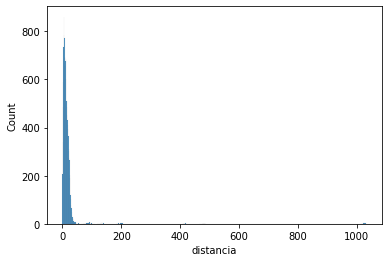

In [46]:
# Histograma da variável distância

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.histplot(data=dfMerged_group,x='distancia')

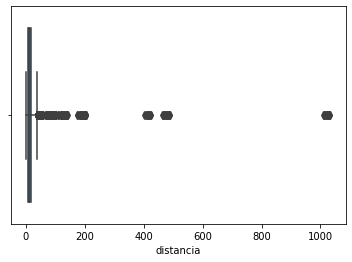

In [47]:
# Boxplot da variável distância

sns.boxplot(x=dfMerged_group["distancia"])

In [48]:
# Investigando os ceps que são outliers no cálculo da distância

dfMerged_group[dfMerged_group.distancia > 60].id_cep.value_counts()

72415.0    48
72410.0    46
72430.0    39
73330.0    36
71503.0    29
70630.0    24
72594.0    23
73150.0    14
72457.0    14
72549.0     5
Name: id_cep, dtype: int64

In [49]:
# Cada CEP foi verificado no Google Maps e as coordenadas foram diferentes das informações do nosso dataset

ceps_outliers = [72410,72430,71503,70630,72594,72457,72415,73150,72549,73330]
cep_correcao = dfCepsDF.loc[dfCepsDF['id_cep'].isin(ceps_outliers)]

ind1 = cep_correcao.index
lat_alt = [-15.85177,-15.72028,-16.01446,-16.01721,-16.00695,-16.00918,-16.05279,-15.99645,-15.60197,-15.60946]
lon_alt = [-47.94817,-47.88104,-48.05283,-48.08201,-48.05993,-48.06418,-47.98158,-47.99895,-47.87104,-47.87104]

for i1,la, lo in zip(ind1,lat_alt, lon_alt):
  dfCepsDF.iloc[i1,1] = la
  dfCepsDF.iloc[i1,2] = lo

In [50]:
# Corrigindo todo o dataframe e calculando as novas distâncias

dfMerged_group.drop(['lat_resid','lon_resid','coor_estab','coor_resid','distancia'],axis='columns',inplace=True)

dfMerged_group = pd.merge(dfMerged_group,dfCepsDF)
dfMerged_group.rename(columns={"lat":"lat_resid","lon":"lon_resid"},inplace=True)

dfMerged_group['coor_estab'] = list(zip(dfMerged_group.lat_estab,dfMerged_group.lon_estab))
dfMerged_group['coor_resid'] = list(zip(dfMerged_group.lat_resid,dfMerged_group.lon_resid))

distancia.clear()
for index,row in dfMerged_group.iterrows():
    distancia.append(hs.haversine(row['coor_estab'],row['coor_resid']))

dfMerged_group['distancia'] = distancia
dfMerged_group.head()


,estabelecimento_id,id_cep,contador,lat_estab,lon_estab,lat_resid,lon_resid,coor_estab,coor_resid,distancia
0,10456,70002.0,4,-15.800697,-47.889197,-15.79084,-47.879656,"(-15.80069669087728, -47.8891970316569)","(-15.7908403078715, -47.87965647379557)",1.497736
1,10464,70002.0,2,-15.767055,-47.876769,-15.79084,-47.879656,"(-15.767054516336191, -47.87676935610564)","(-15.7908403078715, -47.87965647379557)",2.662845
2,10472,70002.0,5,-15.871168,-47.980211,-15.79084,-47.879656,"(-15.871167599713361, -47.98021073517977)","(-15.7908403078715, -47.87965647379557)",13.981938
3,10480,70002.0,2,-15.825485,-48.095874,-15.79084,-47.879656,"(-15.825484525073659, -48.095874410687095)","(-15.7908403078715, -47.87965647379557)",23.451626
4,10499,70002.0,8,-15.808742,-48.060183,-15.79084,-47.879656,"(-15.80874183361347, -48.06018289419321)","(-15.7908403078715, -47.87965647379557)",19.417546


In [51]:
# Análise da variável distância após correção

dfMerged_group.distancia.describe()

count    14840.000000
mean        12.862542
std          8.088737
min          0.000000
25%          6.423054
50%         11.476958
75%         18.178408
max         57.674670
Name: distancia, dtype: float64

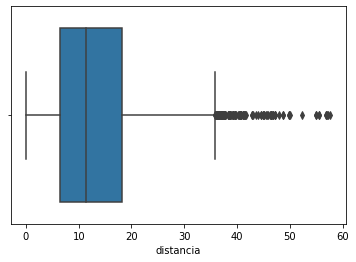

In [52]:
# Boxplot da variável distância após alteração

sns.boxplot(x=dfMerged_group["distancia"])

In [53]:
# Distâncias de forma decrescente
dfMerged_group.sort_values(by='distancia',ascending=False,inplace=True)
dfMerged_group.head()

,estabelecimento_id,id_cep,contador,lat_estab,lon_estab,lat_resid,lon_resid,coor_estab,coor_resid,distancia
10183,10847,73380.0,2,-16.005841,-48.052746,-15.618128,-47.694655,"(-16.005841, -48.052746)","(-15.618128256364303, -47.69465533169833)",57.674670
14527,9056963,72668.0,1,-15.812510,-48.016860,-16.318696,-48.112447,"(-15.812510419247756, -48.0168599940058)","(-16.31869648348901, -48.112447184901086)",57.204593
14115,5717515,73499.0,1,-16.011471,-48.015217,-15.766445,-47.546089,"(-16.01147123129971, -48.01521705719362)","(-15.76644515991211, -47.54608917236328)",57.092230
14489,10901,72199.0,1,-15.826443,-48.074629,-15.766445,-47.546089,"(-15.826443090892973, -48.074629393078034)","(-15.76644515991211, -47.54608917236328)",56.943721
14488,10626,72199.0,1,-15.826443,-48.074629,-15.766445,-47.546089,"(-15.826443090892973, -48.074629393078034)","(-15.76644515991211, -47.54608917236328)",56.943721


In [54]:
# Lista das residências de pacientes que percorreram mais de 30km para ir até o posto de vacinação

resid_maior30 = dfMerged_group[dfMerged_group.distancia > 30].id_cep.value_counts()
df_resid_maior30 = dfCepsDF.loc[dfCepsDF['id_cep'].isin(resid_maior30.index)]
df_resid_maior30.reset_index(inplace=True)
df_resid_maior30.head()

,index,id_cep,lat,lon
0,0,70002,-15.790840,-47.879656
1,27,70070,-15.800514,-47.886993
2,40,70092,-15.803815,-47.884109
3,60,70237,-15.811344,-47.888659
4,62,70239,-15.815324,-47.891238


In [55]:
# Análise dos pontos de vacinação mais cheios

dfUBS_count = dfMerged_group.groupby('estabelecimento_id')['contador'].agg('sum')
dfUBS_count = pd.merge(dfUBS_count,dfPostosDF[['estabelecimento_id','nm_fantasia','lat','lon']],on='estabelecimento_id')
dfUBS_count.sort_values(ascending=False,by='contador',inplace=True)
top10UBS = dfUBS_count.head(10)
top10UBS.reset_index(inplace=True,drop=True)
top10UBS


,estabelecimento_id,contador,nm_fantasia,lat,lon
0,11150,10405,UBS 01 ASA SUL,-15.821936,-47.890604
1,10723,6968,UBS 2 ASA NORTE,-15.749557,-47.891830
2,9056963,6112,UBS 01 VICENTE PIRES,-15.812510,-48.016860
3,9578277,4737,POLICLINICA LAGO SUL,-15.856494,-47.864011
4,10758,4601,UBS 2 CRUZEIRO,-15.789750,-47.939987
5,11010,4284,UBS 5 CEILANDIA,-15.807501,-48.106616
6,10774,3690,UBS 02 SAMAMBAIA,-15.869926,-48.103894
7,10626,3597,UBS 05 TAGUATINGA,-15.826443,-48.074629
8,11266,3431,UBS 02 GUARA,-15.829806,-47.971829
9,10901,3428,UBS 01 TAGUATINGA,-15.826443,-48.074629


In [59]:
# Criando marcadores

from folium.plugins import MeasureControl

m1 = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

ubs = fl.FeatureGroup(name='UBS DF - Pontos de vacinação Covid-19')
for i in range(0,len(dfPostosGeo)): 
  fl.Marker([dfPostosGeo.loc[i,'lat'],dfPostosGeo.loc[i,'lon']],
  icon=fl.Icon(color='blue'),
  tooltip= dfPostosGeo.loc[i,'nm_fantasia'],
  ).add_to(ubs)
 
resid = fl.FeatureGroup(name='Deslocamento > 30 km')
for i in range(0,len(df_resid_maior30)):
  fl.Circle([df_resid_maior30.loc[i,'lat'],df_resid_maior30.loc[i,'lon']],
  color='red',
  ).add_to(resid)

top10 = fl.FeatureGroup(name='Pontos de vacinação mais cheios')
for i in range(0,len(top10UBS)):
  fl.Marker([top10UBS.loc[i,'lat'],top10UBS.loc[i,'lon']],
  icon=fl.Icon(color='red'),
  tooltip= top10UBS.loc[i,'nm_fantasia'],
  ).add_to(top10)

m1.add_child(resid)
m1.add_child(ubs)
m1.add_child(top10)
m1.add_child(MeasureControl())
m1.add_child(fl.LatLngPopup())
fl.LayerControl().add_to(m1)

m1.save('mapa.html')

m1

In [57]:
#Construção do mapa de calor

dfHeat = dfMerged.groupby(['data_aplicacao','id_cep']).size().reset_index(name='contador')
dfHeat = pd.merge(dfHeat,dfCepsDF[['lat','lon','id_cep']],on='id_cep')
plotHeat = dfHeat[['lat','lon','contador']].values.tolist()

m2 = fl.Map(location=[-15.7751257, -48.0785352],tiles='OpenStreetMap',zoom_control=False)

from folium.plugins import HeatMap
heatmap = HeatMap(plotHeat,radius=18).add_to(m2)
heatmap.save('mapa_calor.html')
m2



In [58]:
# Fechando conexão
postgreSQLConnection.close()